In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import shutil
import zipfile
from pathlib import Path

workdir = '/content'
os.chdir(workdir)

drive_base = '/content/drive/Shareddrives/NLP/entrega2_preprocessing+embeddings'
zip_files = [
    'output.zip',
    'bag_of_words.zip',
    'tf_idf.zip'
]

dest_root = Path(workdir)
dest_root.mkdir(parents=True, exist_ok=True)

for fname in zip_files:
    src_path = Path(drive_base) / fname
    local_zip = Path(workdir) / fname

    shutil.copy(str(src_path), str(local_zip))

    target_dir = dest_root / local_zip.stem
    target_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(local_zip, 'r') as z:
        z.extractall(target_dir)

    print(f'✅ {fname} extraído en: {target_dir}')

!ls -lah "$dest_root"

✅ output.zip extraído en: /content/output
✅ bag_of_words.zip extraído en: /content/bag_of_words
✅ tf_idf.zip extraído en: /content/tf_idf
total 120M
drwxr-xr-x 1 root root 4.0K Nov 28 17:48 .
drwxr-xr-x 1 root root 4.0K Nov 28 17:12 ..
drwxr-xr-x 2 root root 4.0K Nov 28 17:48 bag_of_words
-rw------- 1 root root 394K Nov 28 17:48 bag_of_words.zip
drwxr-xr-x 4 root root 4.0K Nov 20 14:30 .config
drwx------ 5 root root 4.0K Nov 28 17:45 drive
drwxr-xr-x 3 root root 4.0K Nov 28 17:48 output
-rw------- 1 root root 119M Nov 28 17:48 output.zip
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
drwxr-xr-x 2 root root 4.0K Nov 28 17:48 tf_idf
-rw------- 1 root root 1.1M Nov 28 17:48 tf_idf.zip


##### Carga de dependencias principales

In [5]:
!pip install spacy scikit-learn
!pip install rouge-score -q
!python -m spacy download es_core_news_sm
!pip install gensim
!pip install fasttext

import pandas as pd
import spacy
import unicodedata
import re
import csv
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import unicodedata
import re
from pathlib import Path
import pickle
import torch
import fasttext
import numpy as np

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans

from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 134.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498209 sha256=23d80559044218fbed03f923

### TÉCNICAS DE SHALLOW LEARNING

#### TF-IDF + TextRank

* Sanity check para transcripciones problemáticas

In [ ]:
# === 1. Cargar archivo ===
file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt"
df = pd.read_csv(file_path)

# Verificar columna
if 'text' not in df.columns:
    raise ValueError("El archivo debe contener una columna llamada 'text'.")

print(f"Filas: {len(df)} | Columnas: {df.columns.tolist()}")

Filas: 633 | Columnas: ['video_id', 'chunk_id', 'text', 'sentimiento']


In [ ]:
# === 1. Cargar archivo ===

transcription_names = ['ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt',
                       'Analizamos el ACUERDO COMERCIAL entre la UE y EEUU_conTags.txt',
                       'ARANCELES_ TRUMP REVIENTA SU PROPIA BOLSA_conTags',
                       'CARCEL por PROTESTAR(con Francho AIJON)_conTags',
                       'Caso MONTORO_ COMO FUNCIONAN las CLOACAS_conTags',
                       'CAYENDO por su propo Peso_conTags',
                       'COMUNICACION POLITICA y HEGEMONIA_conTags',
                       'Cuanta PRESION puede AGUANTAR Israel_conTags',
                       'EL BRAZO ARMADO de TRUMP_conTags',
                       'El SINTOMA de un ENORME PROBLEMA POLITICO_conTags']


file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt"
file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/Analizamos el ACUERDO COMERCIAL entre la UE y EEUU_conTags.txt"

df = pd.read_csv(file_path)

# Verificar columna
if 'text' not in df.columns:
    raise ValueError("El archivo debe contener una columna llamada 'text'.")

print(f"Filas: {len(df)} | Columnas: {df.columns.tolist()}")

Filas: 418 | Columnas: ['video_id', 'chunk_id', 'text', 'sentimiento']


In [ ]:
transcription_names = ["ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt",
                       "Analizamos el ACUERDO COMERCIAL entre la UE y EEUU_conTags.txt",
                       "ARANCELES_ TRUMP REVIENTA SU PROPIA BOLSA_conTags.txt",
                       "CARCEL por PROTESTAR(con Francho AIJON)_conTags.txt",
                       "Caso MONTORO_ COMO FUNCIONAN las CLOACAS_conTags.txt",
                       "CAYENDO por su propo Peso_conTags.txt",
                       "COMUNICACION POLITICA y HEGEMONIA_conTags.txt",
                       "Cuanta PRESION puede AGUANTAR Israel_conTags.txt",
                       "EL BRAZO ARMADO de TRUMP_conTags.txt",
                       "El SINTOMA de un ENORME PROBLEMA POLITICO_conTags.txt"]

for transcription_name in transcription_names:
  file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/" + transcription_name
  df = pd.read_csv(file_path)
  expected_cols = None
  problematic_rows = []

  with open(file_path, 'r', encoding='utf-8') as f:
      reader = csv.reader(f)
      for i, row in enumerate(reader):
          if i == 0:
              expected_cols = len(row)
          else:
              if len(row) != expected_cols:
                  problematic_rows.append((i+1, len(row), row))

  print(f"Sanity check for: {transcription_name}")
  print(f"Número esperado de columnas: {expected_cols}")
  print(f"Total filas problemáticas: {len(problematic_rows)}")

  # Mostrar las primeras 10 filas problemáticas
  for r in problematic_rows[:10]:
      print(f"Línea {r[0]} -> columnas: {r[1]} | contenido: {r[2]}")


Sanity check for: ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: Analizamos el ACUERDO COMERCIAL entre la UE y EEUU_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: ARANCELES_ TRUMP REVIENTA SU PROPIA BOLSA_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: CARCEL por PROTESTAR(con Francho AIJON)_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: Caso MONTORO_ COMO FUNCIONAN las CLOACAS_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: CAYENDO por su propo Peso_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: COMUNICACION POLITICA y HEGEMONIA_conTags.txt
Número esperado de columnas: 4
Total filas problemáticas: 0
Sanity check for: Cuanta PRESION puede AGUANTAR Israel_conTags.txt
Número esperado de column

In [ ]:
file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt"
df = pd.read_csv(file_path)

# === 2. Cargar modelo spaCy ===
nlp = spacy.load("es_core_news_sm", disable=["ner"])

def normalize_text(text: str) -> str:
    return unicodedata.normalize("NFKC", text).lower()

def clean_with_spacy(text: str, remove_stopwords=True, lemmatize=True) -> str:
    doc = nlp(normalize_text(text))
    tokens = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        if remove_stopwords and tok.is_stop:
            continue
        tokens.append(tok.lemma_ if lemmatize else tok.text)
    return " ".join(tokens)

# === 3. Limpiar todas las frases ===
df['text_clean'] = df['text'].apply(lambda x: clean_with_spacy(str(x)))
print("Ejemplo limpieza:")
print(df[['text', 'text_clean']].head(5))

# === 4. Calcular TF-IDF ===
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text_clean'])
print("Forma matriz TF-IDF:", tfidf_matrix.shape)

# === 5. Calcular similitud y aplicar TextRank ===
similarity_matrix = cosine_similarity(tfidf_matrix)
np.fill_diagonal(similarity_matrix, 0)
graph = nx.from_numpy_array(similarity_matrix)
scores = nx.pagerank(graph)

# === 6. Seleccionar frases más relevantes ===
ranked_sentences = sorted(((score, idx) for idx, score in scores.items()), reverse=True)
N = 5  # número de frases en el resumen
summary_sentences = [df['text'][idx] for _, idx in ranked_sentences[:N]]

print("\nResumen generado con TextRank:")
for i, sentence in enumerate(summary_sentences, 1):
    print(f"{i}. {sentence}")

# === 7. Guardar resumen ===
summary_df = pd.DataFrame({'resumen': summary_sentences})
summary_df.to_csv("resumen_textrank.csv", index=False)
print("\nResumen guardado en: resumen_textrank.csv")


Ejemplo limpieza:
                                                text  \
0  Bienvenidos a otro programa de Ampliando el De...   
1  Ya sabéis que yo tengo la sagrada costumbre de...   
2  La gravedad del hecho en sí, que al final no e...   
3  donde la miseria, la soledad y otras grandes o...   
4  Eso no parece importarle a mis los patriotas, ...   

                                          text_clean  
0  bienvenido programa ampliar debate decidir gra...  
1  sabéis sagrado costumbre verano trabajar vago ...  
2  gravedad agresión chaval mil país anciano cole...  
3                   miseria soledad problema acechar  
4  importar él patriota convertir enorme bola odi...  
Forma matriz TF-IDF: (633, 2185)

Resumen generado con TextRank:
1. Claro, es que eh Claro, claro.
2. Esa es buena también, ¿eh?
3. E lo primero que tú vas a hacer cuando te traen una persona con de expulsión va a ser eh citar pues el arraigo eh por porque esa persona tiene derecho a estar tiene derecho a estar en

##### Evaluación con resumen de referencia usando ROUGE

In [ ]:
# 1. Load reference summary
summary_path = '/content/drive/Shareddrives/NLP/transcription_summaries/summaries/ABOGADOS TUMBAN los BULOS sobre EXTRANJERÍA_summary.txt'

with open(summary_path, 'r', encoding='utf-8') as f:
    reference_summary = f.read().strip()

print("Reference Summary:\n", reference_summary)

# 2. Combine generated summary sentences into one string
generated_summary = " ".join(summary_sentences)
print("\nGenerated Summary:\n", generated_summary)

# 3. Install and import ROUGE scorer
# !pip install rouge-score -q
from rouge_score import rouge_scorer

# 4. Compute ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference_summary, generated_summary)

# 5. Display results
print("\n=== ROUGE Scores ===")
for metric, result in scores.items():
    print(f"{metric}: F1={result.fmeasure:.4f}, Precision={result.precision:.4f}, Recall={result.recall:.4f}")


Reference Summary:
 Este programa desmonta los bulos racistas sobre la extranjería en España, explicando el marco legal real. Se aclara que la Ley de Extranjería y el Código Penal sí permiten la expulsión de extranjeros en situación irregular o que cometan delitos, desmintiendo la narrativa de impunidad. Se critica la confusión interesada entre el gobierno, la administración y el poder judicial, y se denuncia que el discurso de la ultradereja sobre "deportaciones masivas" es una apuesta por la arbitrariedad premoderna y el "derecho penal del enemigo", que elimina las garantías procesales individuales. El análisis concluye que este racismo, basado en falsedades, busca crear un chivo expiatorio y oculta la explotación económica de la mano de obra migrante.

Generated Summary:
 Claro, es que eh Claro, claro. Esa es buena también, ¿eh? E lo primero que tú vas a hacer cuando te traen una persona con de expulsión va a ser eh citar pues el arraigo eh por porque esa persona tiene derecho a est

##### Plot of most central sentences

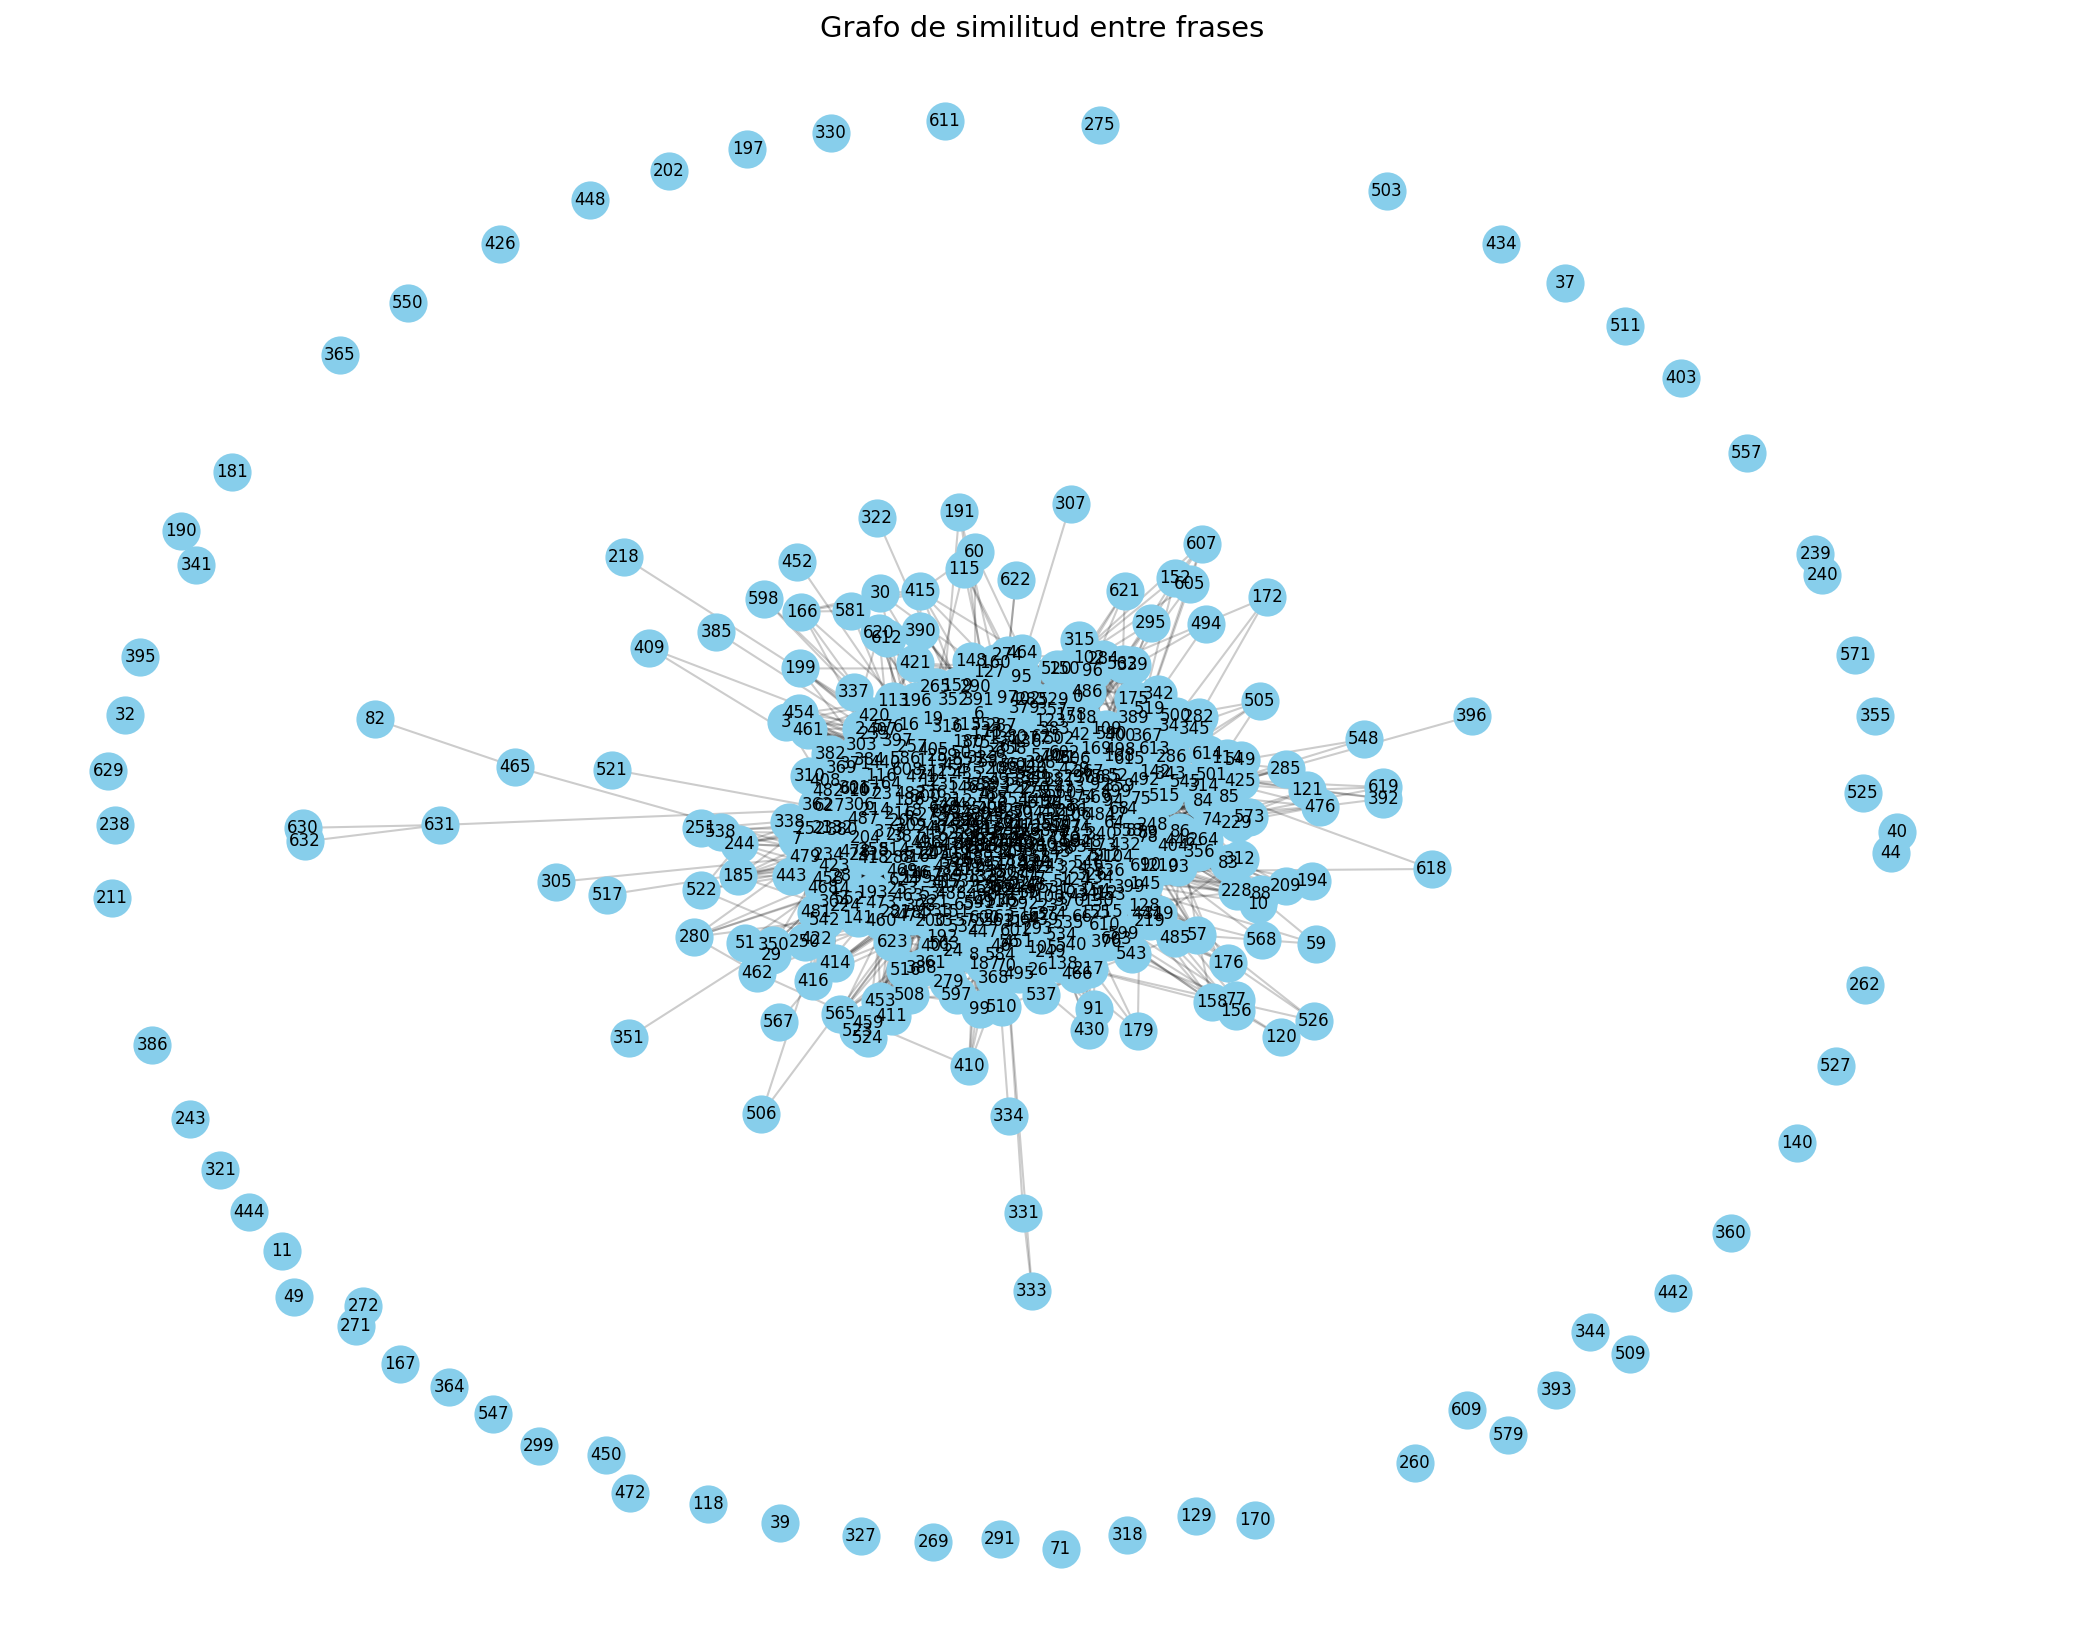

Imagen guardada en: grafo_textrank_simple.png


In [ ]:

import matplotlib.pyplot as plt
import networkx as nx

# Suponiendo que ya tienes el grafo creado:
graph = nx.from_numpy_array(similarity_matrix)

# Layout para los nodos
pos = nx.spring_layout(graph, seed=42)

# Tamaño y color fijos para todos los nodos
node_sizes = 300
node_colors = "skyblue"

# Etiquetas: solo índices
labels = {node: str(node) for node in graph.nodes()}

# Dibujar grafo
plt.figure(figsize=(14, 11), dpi=150)
nx.draw_networkx_edges(graph, pos, alpha=0.2)
nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)

plt.title("Grafo de similitud entre frases", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('grafo_textrank_simple.png', dpi=200)
plt.show()

print("Imagen guardada en: grafo_textrank_simple.png")


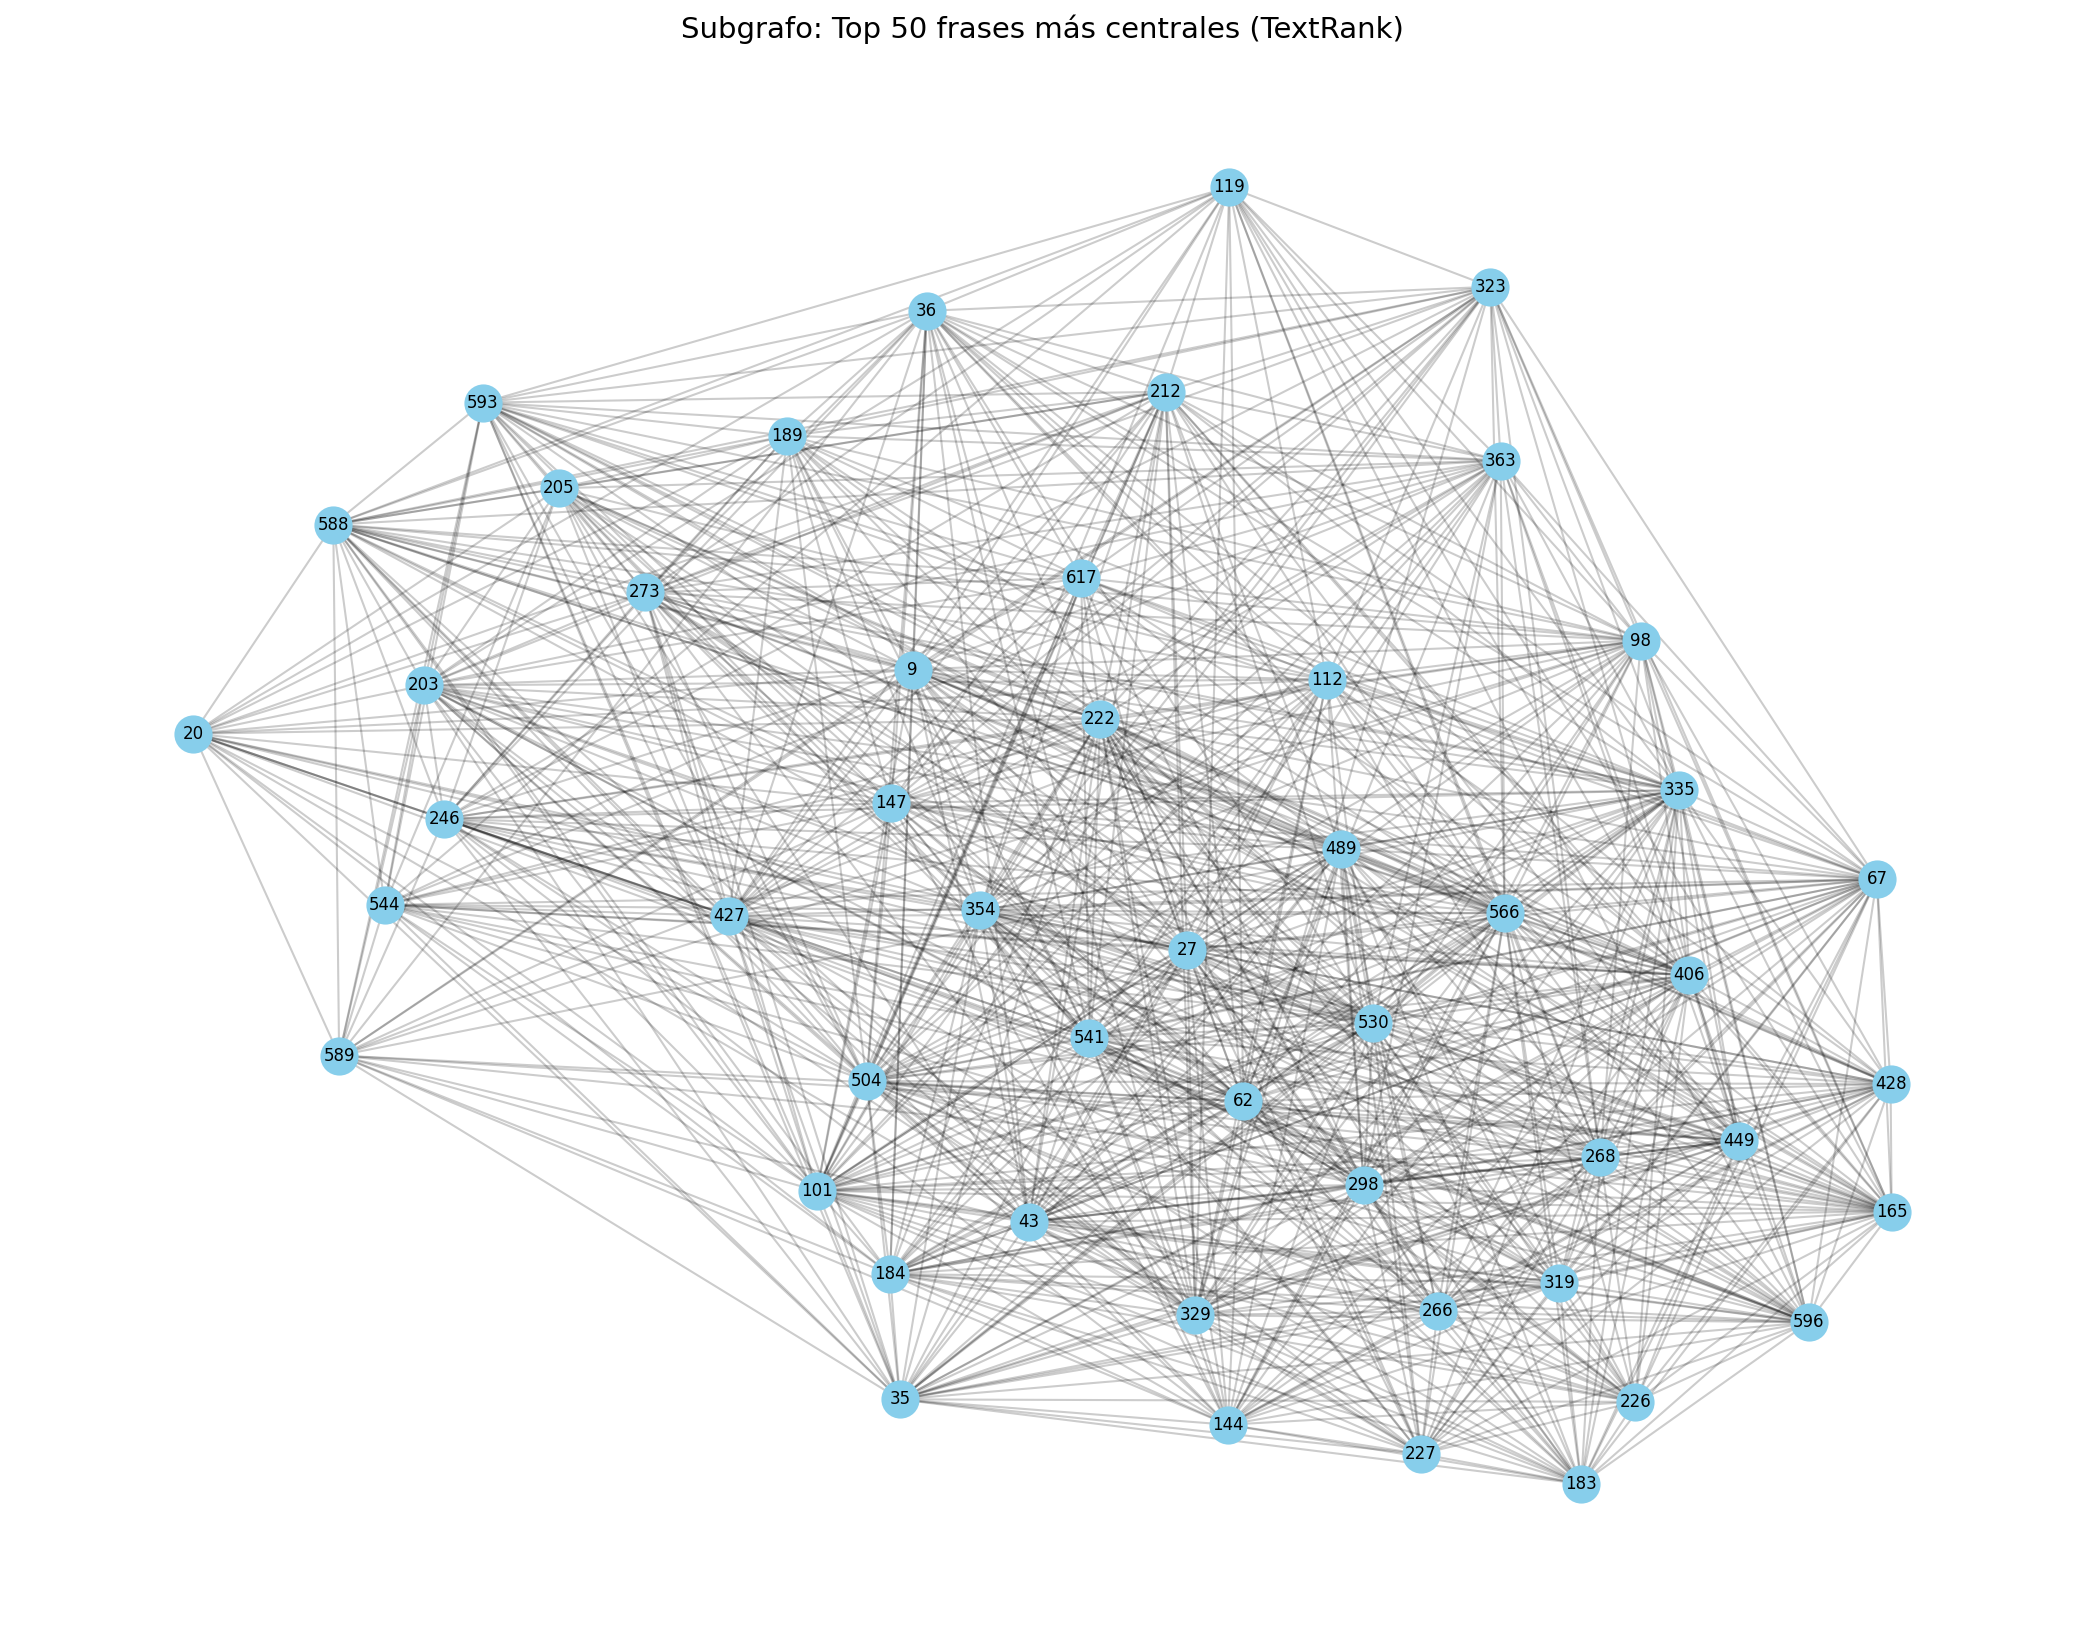

Imagen guardada en: subgrafo_textrank_top50_simple.png


In [ ]:
scores = nx.pagerank(graph)

# === 3. Seleccionar los nodos más centrales (Top 50) ===
top_n = 50
sorted_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)
top_nodes = [node for node, _ in sorted_nodes[:top_n]]

# Crear subgrafo con los nodos más importantes
subgraph = graph.subgraph(top_nodes)

# === 4. Visualización del subgrafo con estilo simple ===
pos = nx.spring_layout(subgraph, seed=42)

# Tamaño y color fijos para todos los nodos
node_sizes = 300
node_colors = "skyblue"

# Etiquetas: solo índices
labels = {node: str(node) for node in subgraph.nodes()}

# Dibujar grafo
plt.figure(figsize=(14, 11), dpi=150)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

plt.title(f"Subgrafo: Top {top_n} frases más centrales (TextRank)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('subgrafo_textrank_top50_simple.png', dpi=200)
plt.show()

print("Imagen guardada en: subgrafo_textrank_top50_simple.png")


#### Bag of Words + Clustering

Resumen extractivo a partir de la frase más central de cada tema principal del tema

In [ ]:
# =========================
# 1) Cargar datos
# =========================
file_path = "/content/drive/Shareddrives/NLP/chunks_conTags/ABOGADOS TUMBAN los BULOS sobre EXTRANJERIA_conTags.txt"
df = pd.read_csv(file_path)

# =========================
# 2) spaCy para limpieza (stopwords y lematización)
# =========================
nlp = spacy.load("es_core_news_sm", disable=["ner"])

def normalize_text(text: str) -> str:
    return unicodedata.normalize("NFKC", text).lower()

def clean_with_spacy(text: str, remove_stopwords=True, lemmatize=True) -> str:
    doc = nlp(normalize_text(text))
    tokens = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        if remove_stopwords and tok.is_stop:
            continue
        tokens.append(tok.lemma_ if lemmatize else tok.text)
    return " ".join(tokens)

# Limpiamos todas las frases
df['text_clean'] = df['text'].apply(lambda x: clean_with_spacy(str(x)))
print("Ejemplo limpieza:")
print(df[['text', 'text_clean']].head(5))

# =========================
# 3) Bag-of-Words por frase
# =========================
# Usamos CountVectorizer sobre las frases ya limpias (stopwords eliminadas por spaCy)
vectorizer_bow = CountVectorizer(
    lowercase=False,         # ya lo hicimos en normalize_text
    min_df=2,                # ajusta según tamaño (para evitar términos rarísimos)
    max_df=0.95,             # elimina términos demasiado frecuentes
    # stop_words=None        # no hace falta: ya se eliminaron con spaCy
)
X_bow = vectorizer_bow.fit_transform(df['text_clean'])
print("Forma matriz BoW:", X_bow.shape)

# =========================
# 4) Clustering de frases (MiniBatchKMeans) + selección representativa
# =========================
# N = nº de frases del resumen (elige el tamaño deseado)
N = 5
n_clusters = min(N, X_bow.shape[0])  # no más clústeres que frases

mbk = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=1024,
    n_init="auto"
)
labels = mbk.fit_predict(X_bow)

# Para cada clúster, elegimos la frase más representativa (menor distancia al centroide)
summary_sentences = []
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    if len(cluster_indices) == 0:
        continue

    # Distancia de cada frase del clúster a su centroide
    # MiniBatchKMeans.transform(X) devuelve distancias a todos los centroides
    dists = mbk.transform(X_bow[cluster_indices])[:, cluster_id]
    best_local = cluster_indices[np.argmin(dists)]
    summary_sentences.append((best_local, df['text'].iloc[best_local]))

# Ordenamos por posición original para coherencia
summary_sentences = sorted(summary_sentences, key=lambda x: x[0])
summary_text = " ".join([s for _, s in summary_sentences])

print("\n=== Resumen (Bag-of-Words + Clustering) ===")
for i, (_, sent) in enumerate(summary_sentences, 1):
    print(f"{i}. {sent}")

# =========================
# 5) Evaluación con ROUGE (contra resumen de referencia)
# =========================
summary_path = '/content/drive/Shareddrives/NLP/transcription_summaries/summaries/ABOGADOS TUMBAN los BULOS sobre EXTRANJERÍA_summary.txt'
with open(summary_path, 'r', encoding='utf-8') as f:
    reference_summary = f.read().strip()

generated_summary = summary_text

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
scores = scorer.score(reference_summary, generated_summary)

print("\n=== ROUGE ===")
for metric, result in scores.items():
    print(f"{metric}: F1={result.fmeasure:.4f} | P={result.precision:.4f} | R={result.recall:.4f}")

# =========================
# 6) Guardar resumen y métricas
# =========================
out_summary_csv = "resumen_bow_clustering.csv"
out_scores_csv  = "rouge_bow_clustering.csv"

pd.DataFrame({'resumen': [generated_summary]}).to_csv(out_summary_csv, index=False)

pd.DataFrame({
    'metric': ['rouge1','rouge2','rougeL'],
    'f1': [scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure],
    'precision': [scores['rouge1'].precision, scores['rouge2'].precision, scores['rougeL'].precision],
    'recall': [scores['rouge1'].recall, scores['rouge2'].recall, scores['rougeL'].recall],
    'method': ['BoW+Clustering']*3
}).to_csv(out_scores_csv, index=False)

print(f"\nResumen guardado en: {out_summary_csv}")
print(f"Métricas ROUGE guardadas en: {out_scores_csv}")


Ejemplo limpieza:
                                                text  \
0  Bienvenidos a otro programa de Ampliando el De...   
1  Ya sabéis que yo tengo la sagrada costumbre de...   
2  La gravedad del hecho en sí, que al final no e...   
3  donde la miseria, la soledad y otras grandes o...   
4  Eso no parece importarle a mis los patriotas, ...   

                                          text_clean  
0  bienvenido programa ampliar debate decidir gra...  
1  sabéis sagrado costumbre verano trabajar vago ...  
2  gravedad agresión chaval mil país anciano cole...  
3                   miseria soledad problema acechar  
4  importar él patriota convertir enorme bola odi...  
Forma matriz BoW: (633, 779)

=== Resumen (Bag-of-Words + Clustering) ===
1. No, no es nada más que eso.
2. Eh, eh, son son son preguntas, la gente se lo prepara.
3. Estamos en un régimen parlamentario.
4. Le acabas de condenar una niña de 8 años.
5. Van a tirarle piedra a los sitios donde saben que hay extranjero

### TÉCNICAS DE DEEP LEARNING

LSTMs + Word2Vec

##### Definición del modelo

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
# from rouge_score import rouge_scorer  # suponiendo que ya lo usas
# import fasttext  # ya lo cargas más abajo
# import gensim.models.keyedvectors as kv  # si usas Word2Vec gensim

# -------------------------
# Bahdanau Attention (igual que el tuyo)
# -------------------------
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_dim, dec_dim)
        self.W2 = nn.Linear(dec_dim, dec_dim)
        self.V = nn.Linear(dec_dim, 1)

    def forward(self, enc_outputs, hidden, mask):
        # enc_outputs: [batch, src_len, enc_dim]
        # hidden: [batch, dec_dim]
        score = self.V(torch.tanh(self.W1(enc_outputs) + self.W2(hidden.unsqueeze(1))))
        score = score.squeeze(2)  # [batch, src_len]
        score = score.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(score, dim=1)  # [batch, src_len]
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)  # [batch, enc_dim]
        return context, attn_weights

# -------------------------
# Encoder (Bidirectional LSTM)
# -------------------------
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout, emb_matrix=None, trainable=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(emb_matrix))
            self.embedding.weight.requires_grad = trainable
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, lengths):
        # src: [B, S]; lengths: [B]
        embedded = self.dropout(self.embedding(src))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, (hidden, cell) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        # outputs: [B, S, hidden_dim*2]
        # hidden: [n_layers*2, B, hidden_dim]
        return outputs, hidden, cell

# -------------------------
# Decoder con Atención
# -------------------------
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = BahdanauAttention(hidden_dim * 2, hidden_dim)
        self.lstm = nn.LSTM(embed_dim + hidden_dim * 2, hidden_dim, n_layers,
                            dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim + hidden_dim * 2 + embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs, mask):
        # input: [B]  (token ids)
        input = input.unsqueeze(1)  # [B, 1]
        embedded = self.dropout(self.embedding(input))  # [B, 1, embed_dim]
        # hidden: [n_layers, B, hidden_dim] -> take top layer's hidden for attention
        context, attn_weights = self.attention(encoder_outputs, hidden[-1], mask)
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        output = output.squeeze(1)  # [B, hidden_dim]
        prediction = self.fc_out(torch.cat((output, context, embedded.squeeze(1)), dim=1))  # [B, vocab]
        return prediction, hidden, cell, attn_weights

# -------------------------
# Seq2Seq Wrapper con funciones utilitarias
# -------------------------
class Seq2SeqSummarizer(nn.Module):
    def __init__(self, encoder, decoder, device, hidden_dim=None, n_layers=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        # Proyección para mapear hidden bidireccional -> decoder hidden (por capa)
        # recogemos dimensiones si no se pasan
        enc_hidden_dim = encoder.lstm.hidden_size
        enc_num_layers = encoder.lstm.num_layers
        enc_bidirectional = encoder.lstm.bidirectional
        if hidden_dim is None:
            hidden_dim = decoder.lstm.hidden_size
        if n_layers is None:
            n_layers = decoder.lstm.num_layers
        # si encoder es bidireccional, creamos lineales por capa para proyectar (h_f,h_b)->h
        if enc_bidirectional:
            self._hidden_proj = nn.ModuleList([
                nn.Linear(enc_hidden_dim * 2, hidden_dim) for _ in range(enc_num_layers)
            ])
            self._cell_proj = nn.ModuleList([
                nn.Linear(enc_hidden_dim * 2, hidden_dim) for _ in range(enc_num_layers)
            ])
        else:
            self._hidden_proj = None
            self._cell_proj = None

    def _convert_encoder_states(self, hidden, cell):
        """
        hidden: [n_layers* (1 or 2), B, hidden_dim_enc]
        convertimos a hidden_dec: [n_layers, B, hidden_dim_dec]
        si bidireccional: concatenamos pares (forward,back) por capa
        """
        enc = self.encoder.lstm
        n_layers_enc = enc.num_layers
        bidir = enc.bidirectional
        h_enc_dim = enc.hidden_size

        if bidir:
            # hidden: [n_layers*2, B, h_enc_dim] -> reorganizar por capa
            # para cada capa i: forward = hidden[2*i], backward = hidden[2*i+1]
            hs = []
            cs = []
            for i in range(n_layers_enc):
                h_f = hidden[2 * i]      # [B, h_enc_dim]
                h_b = hidden[2 * i + 1]  # [B, h_enc_dim]
                h_cat = torch.cat((h_f, h_b), dim=1)  # [B, h_enc_dim*2]
                h_proj = torch.tanh(self._hidden_proj[i](h_cat))  # [B, hidden_dec]
                hs.append(h_proj.unsqueeze(0))  # [1, B, hidden_dec]

                c_f = cell[2 * i]
                c_b = cell[2 * i + 1]
                c_cat = torch.cat((c_f, c_b), dim=1)
                c_proj = torch.tanh(self._cell_proj[i](c_cat))
                cs.append(c_proj.unsqueeze(0))

            hidden_dec = torch.cat(hs, dim=0)  # [n_layers_enc, B, hidden_dec]
            cell_dec = torch.cat(cs, dim=0)
            return hidden_dec.contiguous(), cell_dec.contiguous()

        else:
            # no bidireccional: si dims coinciden, devolver tal cual (podrías proyectar si difieren)
            return hidden, cell

    def forward(self, src, src_mask, trg=None, teacher_forcing_ratio=0.5, max_len=None):
        """
        src: [B, S]
        src_mask: [B, S] (1 where token exists)
        trg: [B, T] optional (if provided -> train / teacher forcing)
        """
        lengths = src_mask.sum(1)
        batch_size = src.size(0)
        encoder_outputs, hidden, cell = self.encoder(src, lengths)
        # convertimos hidden/cell bidireccional -> decoder initial states
        hidden, cell = self._convert_encoder_states(hidden, cell)

        if trg is None:
            # inferencia pura; usamos generate en su lugar
            raise ValueError("Si quieres generación llama a model.generate(...)")

        trg_len = trg.size(1)
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        input_tok = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input_tok, hidden, cell, encoder_outputs, src_mask)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_tok = trg[:, t] if teacher_force else top1

        return outputs

    @torch.no_grad()
    def generate(self, src, src_mask, max_len=None, sos_idx=2, eos_idx=3):
        """
        Generación greedy.
        src: [B, S], src_mask: [B, S]
        retorna: [B, out_len] ids
        """
        self.eval()
        max_len = src_mask.size(1) if max_len is None else max_len
        lengths = src_mask.sum(1)
        encoder_outputs, hidden, cell = self.encoder(src, lengths)
        hidden, cell = self._convert_encoder_states(hidden, cell)

        batch_size = src.size(0)
        out_ids = torch.full((batch_size, max_len), fill_value=0, dtype=torch.long, device=self.device)  # pad
        input_tok = torch.tensor([sos_idx] * batch_size, device=self.device)

        finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)
        for t in range(0, max_len):
            logits, hidden, cell, _ = self.decoder(input_tok, hidden, cell, encoder_outputs, src_mask)
            top1 = logits.argmax(1)  # [B]
            out_ids[:, t] = top1
            input_tok = top1
            finished = finished | (top1 == eos_idx)
            if finished.all():
                break

        return out_ids  # [B, max_len]

# -------------------------
# Utilidades para cargar embeddings
# -------------------------
def build_embedding_matrix_from_fasttext(ft_model, stoi, embed_dim):
    """
    ft_model: modelo fasttext cargado (fasttext.FastText)
    stoi: dict token -> idx
    devuelve np.array (vocab_size, embed_dim)
    """
    vocab_size = len(stoi)
    emb = np.random.normal(0, 0.1, (vocab_size, embed_dim)).astype(np.float32)
    for token, idx in stoi.items():
        try:
            vec = ft_model.get_word_vector(token)
            emb[idx] = vec
        except Exception:
            pass
    return emb

def build_embedding_matrix_from_gensim(keyed_vectors, stoi, embed_dim):
    vocab_size = len(stoi)
    emb = np.random.normal(0, 0.1, (vocab_size, embed_dim)).astype(np.float32)
    for token, idx in stoi.items():
        if token in keyed_vectors:
            emb[idx] = keyed_vectors[token]
    return emb

# --------------
# ids -> texto
# --------------
def ids_to_text(ids, idx2word, pad_idx=0, sos_idx=2, eos_idx=3, stop_at_eos=True):
    words = []
    for i in ids:
        ii = int(i)
        if ii == pad_idx or ii == sos_idx:
            continue
        if stop_at_eos and ii == eos_idx:
            break
        words.append(idx2word.get(ii, "<unk>"))
    return " ".join(words).strip()

def batch_ids_to_texts(batch_ids, idx2word, pad_idx=0, sos_idx=2, eos_idx=3):
    return [ids_to_text(seq, idx2word, pad_idx=pad_idx, sos_idx=sos_idx, eos_idx=eos_idx) for seq in batch_ids]


Función de entrenamiento

In [2]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device, idx2word, max_gen_len=None):
    """Evalúa pérdida y promedia ROUGE-1/2/L en el conjunto val."""
    model.eval()
    total_loss = 0.0
    r1, r2, rL, n = 0.0, 0.0, 0.0, 0

    for batch in tqdm(dataloader, desc="Validation"):
        src_ids = batch['article_input_ids'].to(device)          # [B, S]
        src_mask = batch['article_attention_mask'].to(device)    # [B, S]
        trg_ids = batch['summary_input_ids'].to(device)          # [B, T]
        outputs = model(src_ids, src_mask, trg_ids, teacher_forcing_ratio=0.0)  # no-Teacher en valid
        # Pérdida (desplazar para predecir t+1)
        logits = outputs[:, 1:].contiguous().view(-1, outputs.size(-1))
        tgt = trg_ids[:, 1:].contiguous().view(-1)
        loss = criterion(logits, tgt)
        total_loss += loss.item()

        # Generación greedy para ROUGE
        max_len = trg_ids.size(1) if max_gen_len is None else max_gen_len
        preds_ids = model.generate(src_ids, src_mask, max_len=max_len, sos_idx=sos_idx, eos_idx=eos_idx)
        ref_texts = batch_ids_to_texts(trg_ids.tolist(), idx2word)
        hyp_texts = batch_ids_to_texts(preds_ids.tolist(), idx2word)

        scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
        for ref, hyp in zip(ref_texts, hyp_texts):
            scores = scorer.score(ref, hyp)
            r1 += scores['rouge1'].fmeasure
            r2 += scores['rouge2'].fmeasure
            rL += scores['rougeL'].fmeasure
            n += 1

    avg_loss = total_loss / len(dataloader)
    rouge_scores = {
        'rouge1_f': r1 / max(n, 1),
        'rouge2_f': r2 / max(n, 1),
        'rougeL_f': rL / max(n, 1),
    }
    return avg_loss, rouge_scores


def train_epoch(model, dataloader, criterion, optimizer, device, clip=1.0):
    """Una época de entrenamiento (estilo solicitado)."""
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()

        src_ids = batch['article_input_ids'].to(device)          # [B, S]
        src_mask = batch['article_attention_mask'].to(device)    # [B, S]
        trg_ids = batch['summary_input_ids'].to(device)          # [B, T]

        outputs = model(src_ids, src_mask, trg_ids, teacher_forcing_ratio=0.5)

        # Pérdida desplazada
        logits = outputs[:, 1:].contiguous().view(-1, outputs.size(-1))
        tgt = trg_ids[:, 1:].contiguous().view(-1)

        loss = criterion(logits, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def train_model(model, train_loader, val_loader, optimizer, criterion, device,
                idx2word, num_epochs=10, early_stopping_patience=3, max_gen_len=None, save_path='best_summarizer_model.pth'):
    """Entrenamiento con validación, cálculo de ROUGE y early stopping."""
    model.to(device)
    best_val_loss = float('inf')
    early_stop_counter = 0
    training_stats = []
    best_model_state = None

    print("Starting training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, rouge_scores = evaluate(model, val_loader, criterion, device, idx2word, max_gen_len=max_gen_len)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val   Loss: {val_loss:.4f}")
        print("ROUGE:", {k: f"{v:.4f}" for k, v in rouge_scores.items()})

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'rouge_scores': rouge_scores
        })

        # Early stopping / guardado del mejor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model: val_loss={val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

        if early_stop_counter >= early_stopping_patience:
            print("⛔ Early stopping triggered!")
            break

    # Restaurar el mejor estado
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("🔁 Restored best model state")

    return model, training_stats


Carga FastText

In [9]:
import os, fasttext
EMB_PATH = r"/content/drive/MyDrive/NLP_artifacts/cc.es.300.bin"

print("Loading FastText Spanish model (cc.es.300.bin) ...")
ft = fasttext.load_model(EMB_PATH)
print(f"Loaded model: dim={ft.get_dimension()}, vocab≈{len(ft.get_words())}")

Loading FastText Spanish model (cc.es.300.bin) ...
Loaded model: dim=300, vocab≈2000000


Cargar instancias en español del dataset DACSA

In [ ]:
from datasets import load_dataset
from huggingface_hub import login

login(token="")
dataset = load_dataset("ELiRF/dacsa", "spanish")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.17k [00:00<?, ?B/s]

spanish/train-00000-of-00014.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

spanish/train-00001-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00002-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00003-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00004-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00005-of-00014.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

spanish/train-00006-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00007-of-00014.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

spanish/train-00008-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00009-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00010-of-00014.parquet:   0%|          | 0.00/301M [00:00<?, ?B/s]

spanish/train-00011-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00012-of-00014.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

spanish/train-00013-of-00014.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

spanish/validation-00000-of-00001.parque(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

spanish/test.i-00000-of-00001.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

spanish/test.ni-00000-of-00001.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1802919 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/104052 [00:00<?, ? examples/s]

Generating test.i split:   0%|          | 0/104052 [00:00<?, ? examples/s]

Generating test.ni split:   0%|          | 0/109626 [00:00<?, ? examples/s]

Construir el vocabulario

In [14]:
import random
import spacy
from collections import Counter

# -----------------------
# 1️⃣ Cargar spaCy español
# -----------------------
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

# -----------------------
# 2️⃣ Tokenización eficiente
# -----------------------
def tokenize_spacy_pipe(texts):
    tokens_list = []
    for doc in nlp.pipe(texts, batch_size=500):
        tokens = [tok.text.lower() for tok in doc if not tok.is_space]
        tokens_list.append(tokens)
    return tokens_list

# -----------------------
# 3️⃣ Subset del train
# -----------------------
subset_size = 10000
indices = random.sample(range(len(dataset['train'])), subset_size)
train_subset = dataset['train'].select(indices)

# Extraer columnas como listas
articles = train_subset['article']
summaries = train_subset['summary']

# Concatenar artículo + resumen para vocabulario
texts = [a + " " + s for a, s in zip(articles, summaries)]

# -----------------------
# 4️⃣ Tokenizar y contar palabras
# -----------------------
tokens_list = tokenize_spacy_pipe(texts)

counter = Counter()
for tokens in tokens_list:
    counter.update(tokens)

# -----------------------
# 5️⃣ Construir word2idx
# -----------------------
min_freq = 2  # filtra palabras raras
word2idx = {"<pad>":0, "<unk>":1, "<sos>":2, "<eos>":3}

for word, freq in counter.most_common():
    if freq < min_freq:
        continue
    word2idx[word] = len(word2idx)

# También idx2word por conveniencia
idx2word = {i:w for w,i in word2idx.items()}

print(f"Vocabulario creado: {len(word2idx)} palabras.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 128.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Vocabulario creado: 85307 palabras.


In [16]:
import pickle

# -----------------------
# Guardar word2idx e idx2word
# -----------------------
vocab_path = "/content/drive/MyDrive/NLP_artifacts/word2idx.pkl"
with open(vocab_path, "wb") as f:
    pickle.dump(word2idx, f)

idx2word_path = "/content/drive/MyDrive/NLP_artifacts/idx2word.pkl"
with open(idx2word_path, "wb") as f:
    pickle.dump(idx2word, f)

print("✅ Vocabulario guardado en disco.")


✅ Vocabulario guardado en disco.


#### 1. Entrenamiento con embeddings congelados

In [29]:
import numpy as np

def build_embedding_matrix(word2idx, fasttext_model, embed_dim=300):
    vocab_size = len(word2idx)
    emb_matrix = np.zeros((vocab_size, embed_dim), dtype=np.float32)

    missing = 0
    for word, idx in word2idx.items():
        try:
            emb_matrix[idx] = fasttext_model.get_word_vector(word)
        except:
            missing += 1
            emb_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))

    print("Vectors not found in FastText:", missing)
    return emb_matrix

emb_matrix = build_embedding_matrix(word2idx, ft, embed_dim=300)

Vectors not found in FastText: 0


In [ ]:
emb_trainable = False   # esto congela los embeddings

pad_idx = 0
sos_idx = 2
eos_idx = 3

vocab_size = len(word2idx)
embed_dim = 300
hidden_dim = 256
n_layers = 2
dropout = 0.2

# 1. Cargar FastText
ft = fasttext.load_model("/content/drive/MyDrive/NLP_artifacts/cc.es.300.bin")

# 2. Construir matriz de embeddings FastText → vocabulario propio
emb_matrix = build_embedding_matrix(word2idx, ft, embed_dim=300)

# 3. Instanciar Encoder con embeddings congelados
encoder = Encoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2,
    emb_matrix=emb_matrix,
    trainable=False  # <<< CONGELADO
)

# 4. Decoder normal
decoder = Decoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2
)

# 5. Modelo completo
model = Seq2SeqSummarizer(encoder, decoder, device="cuda").to("cuda")


Vectors not found in FastText: 0


##### Proceso de entrenamiento

In [30]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from collections import Counter
import spacy
import numpy as np
import fasttext

# -----------------------
# 1️⃣ Cargar spaCy español
# -----------------------
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

# -----------------------
# 2️⃣ Dataset PyTorch
# -----------------------
class SummarizationDataset(Dataset):
    def __init__(self, articles, summaries, word2idx, max_len=256):
        self.articles = articles
        self.summaries = summaries
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article_ids = [self.word2idx.get(tok.text.lower(), self.word2idx["<unk>"])
                       for tok in nlp(self.articles[idx]) if not tok.is_space]
        summary_ids = [self.word2idx.get(tok.text.lower(), self.word2idx["<unk>"])
                       for tok in nlp(self.summaries[idx]) if not tok.is_space]

        # <sos> y <eos>
        article_ids = [self.word2idx["<sos>"]] + article_ids[:self.max_len-2] + [self.word2idx["<eos>"]]
        summary_ids = [self.word2idx["<sos>"]] + summary_ids[:self.max_len-2] + [self.word2idx["<eos>"]]

        # Padding
        article_ids += [self.word2idx["<pad>"]] * (self.max_len - len(article_ids))
        summary_ids += [self.word2idx["<pad>"]] * (self.max_len - len(summary_ids))

        # Máscara
        article_mask = [1 if i != self.word2idx["<pad>"] else 0 for i in article_ids]

        return {
            "article_input_ids": torch.tensor(article_ids, dtype=torch.long),
            "article_attention_mask": torch.tensor(article_mask, dtype=torch.float),
            "summary_input_ids": torch.tensor(summary_ids, dtype=torch.long)
        }

# -----------------------
# 3️⃣ Crear subsets reducidos
# -----------------------
subset_train_size = 5000
subset_val_size   = 500

train_indices = random.sample(range(len(dataset['train'])), subset_train_size)
val_indices   = random.sample(range(len(dataset['train'])), subset_val_size)

train_subset = dataset['train'].select(train_indices)
val_subset   = dataset['train'].select(val_indices)

# -----------------------
# 4️⃣ DataLoaders
# -----------------------
max_len = 256
batch_size = 12  # pequeño para evitar OOM

train_loader = DataLoader(
    SummarizationDataset(train_subset['article'], train_subset['summary'], word2idx, max_len),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    SummarizationDataset(val_subset['article'], val_subset['summary'], word2idx, max_len),
    batch_size=batch_size
)

print(f"✅ Train loader: {len(train_loader.dataset)} ejemplos, batch_size={batch_size}")
print(f"✅ Val loader: {len(val_loader.dataset)} ejemplos, batch_size={batch_size}")

# -----------------------
# 5️⃣ FP16 / Mixed precision
# -----------------------
scaler = GradScaler()  # para escalado automático de gradientes

# Ejemplo de entrenamiento de 1 batch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for batch in train_loader:
    src = batch['article_input_ids'].to(device)
    mask = batch['article_attention_mask'].to(device)
    trg = batch['summary_input_ids'].to(device)

    with autocast():  # aquí se hace forward en fp16
        # output = model(src, mask, trg, teacher_forcing_ratio=0.5)
        pass  # reemplaza con tu forward
    break

print("✅ DataLoaders y FP16 listos para entrenamiento.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 100.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✅ Train loader: 5000 ejemplos, batch_size=12
✅ Val loader: 500 ejemplos, batch_size=12


/tmp/ipython-input-3496128764.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # para escalado automático de gradientes


✅ DataLoaders y FP16 listos para entrenamiento.


/tmp/ipython-input-3496128764.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # aquí se hace forward en fp16


In [ ]:
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# CrossEntropy ignorando padding
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Adam para los parámetros entrenables (recuerda que los embeddings están congelados)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

num_epochs = 3
early_stopping_patience = 2
save_path = "/content/drive/MyDrive/NLP_artifacts/best_summarizer_model.pth"

model, training_stats = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    idx2word=idx2word,
    num_epochs=num_epochs,
    early_stopping_patience=early_stopping_patience,
    max_gen_len=max_len,
    save_path=save_path
)


Starting training...

Epoch 1/3


Validation: 100%|██████████| 42/42 [01:41<00:00,  2.41s/it]


Train Loss: 6.9488
Val   Loss: 6.9982
ROUGE: {'rouge1_f': '0.1546', 'rouge2_f': '0.0123', 'rougeL_f': '0.1452'}
✅ Saved new best model: val_loss=6.9982

Epoch 2/3


Validation: 100%|██████████| 42/42 [01:38<00:00,  2.35s/it]


Train Loss: 6.3342
Val   Loss: 7.0350
ROUGE: {'rouge1_f': '0.1356', 'rouge2_f': '0.0112', 'rougeL_f': '0.1212'}
Early stopping counter: 1/2

Epoch 3/3


Validation: 100%|██████████| 42/42 [01:38<00:00,  2.36s/it]

Train Loss: 6.0890
Val   Loss: 7.1040
ROUGE: {'rouge1_f': '0.1619', 'rouge2_f': '0.0132', 'rougeL_f': '0.1513'}
Early stopping counter: 2/2
⛔ Early stopping triggered!
🔁 Restored best model state


In [24]:
import torch, gc

gc.collect()                   # limpiar objetos Python no referenciados
torch.cuda.empty_cache()        # liberar memoria reservada por PyTorch
print(torch.cuda.memory_allocated())  # memoria realmente usada por tensores
print(torch.cuda.memory_reserved())   # memoria reservada por PyTorch


6853578752
10242490368


#### 2. Entrenamiento fine-tuneando embeddings

In [21]:
emb_trainable = True   # esto congela los embeddings

pad_idx = 0
sos_idx = 2
eos_idx = 3

vocab_size = len(word2idx)
embed_dim = 300
hidden_dim = 256
n_layers = 2
dropout = 0.2

# 1. Cargar FastText
ft = fasttext.load_model("/content/drive/MyDrive/NLP_artifacts/cc.es.300.bin")

# 2. Construir matriz de embeddings FastText → vocabulario propio
emb_matrix = build_embedding_matrix(word2idx, ft, embed_dim=300)

# 3. Instanciar Encoder con embeddings congelados
encoder_ft = Encoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2,
    emb_matrix=emb_matrix,
    trainable=True
)

# 4. Decoder normal
decoder_ft = Decoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2
)

# 5. Modelo completo
model_fine_tuning = Seq2SeqSummarizer(encoder_ft, decoder_ft, device="cuda").to("cuda")


Vectors not found in FastText: 0


In [22]:
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# CrossEntropy ignorando padding
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Adam para los parámetros entrenables (recuerda que los embeddings están congelados)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_fine_tuning.parameters()), lr=1e-3)

num_epochs = 3
early_stopping_patience = 2
save_path = "/content/drive/MyDrive/NLP_artifacts/best_summarizer_model_embedding_fine_tuning.pth"

model_fine_tuning, training_stats_fine_tuning = train_model(
    model=model_fine_tuning,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    idx2word=idx2word,
    num_epochs=num_epochs,
    early_stopping_patience=early_stopping_patience,
    max_gen_len=max_len,
    save_path=save_path
)


Starting training...

Epoch 1/3


Validation: 100%|██████████| 42/42 [01:35<00:00,  2.27s/it]


Train Loss: 7.0213
Val   Loss: 7.0348
ROUGE: {'rouge1_f': '0.1506', 'rouge2_f': '0.0130', 'rougeL_f': '0.1394'}
✅ Saved new best model: val_loss=7.0348

Epoch 2/3


Validation: 100%|██████████| 42/42 [01:35<00:00,  2.27s/it]


Train Loss: 6.3486
Val   Loss: 7.0787
ROUGE: {'rouge1_f': '0.1215', 'rouge2_f': '0.0107', 'rougeL_f': '0.1061'}
Early stopping counter: 1/2

Epoch 3/3


Validation: 100%|██████████| 42/42 [01:35<00:00,  2.28s/it]

Train Loss: 6.1038
Val   Loss: 7.1116
ROUGE: {'rouge1_f': '0.1683', 'rouge2_f': '0.0141', 'rougeL_f': '0.1422'}
Early stopping counter: 2/2
⛔ Early stopping triggered!
🔁 Restored best model state


#### 3. Entrenamiento con embeddings Word2Vec entrenados desde 0

In [31]:
from gensim.models import Word2Vec, KeyedVectors

w2v = KeyedVectors.load("/content/drive/Shareddrives/NLP/entrega2_preprocessing+embeddings/word2vec_vectors")

def build_embedding_matrix_w2v(word2idx, w2v, embed_dim=300):
    matrix = np.zeros((len(word2idx), embed_dim))

    for word, idx in word2idx.items():
        if word in w2v:
            matrix[idx] = w2v[word]
        else:
            matrix[idx] = np.random.normal(scale=0.1, size=(embed_dim,))

    print("Embedding matrix shape:", matrix.shape)
    return matrix


emb_matrix = build_embedding_matrix_w2v(word2idx, w2v, embed_dim=300)

encoder_w2v = Encoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2,
    emb_matrix=emb_matrix,
    trainable=True
)

decoder_w2v = Decoder(
    vocab_size=len(word2idx),
    embed_dim=300,
    hidden_dim=256,
    n_layers=2,
    dropout=0.2
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_w2v_from_scratch = Seq2SeqSummarizer(
    encoder_w2v,
    decoder_w2v,
    device=device
).to(device)

print("Modelo Word2Vec listo en:", device)


Embedding matrix shape: (85307, 300)
Modelo Word2Vec listo en: cuda


In [32]:
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Loss (ignora <pad>)
# ==========================================
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_w2v_from_scratch.parameters()),
    lr=1e-3
)

num_epochs = 3
early_stopping_patience = 2
save_path = "/content/drive/MyDrive/NLP_artifacts/best_summarizer_model_word2vec_fc_2.pth"

model_w2v_from_scratch, training_stats_w2v = train_model(
    model=model_w2v_from_scratch,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    idx2word=idx2word,
    num_epochs=num_epochs,
    early_stopping_patience=early_stopping_patience,
    max_gen_len=max_len,
    save_path=save_path
)

print("Entrenamiento con Word2Vec completado.")
print("Mejor modelo guardado en:", save_path)


Starting training...

Epoch 1/3


Validation: 100%|██████████| 42/42 [02:08<00:00,  3.07s/it]


Train Loss: 7.0281
Val   Loss: 7.0676
ROUGE: {'rouge1_f': '0.0244', 'rouge2_f': '0.0020', 'rougeL_f': '0.0230'}
✅ Saved new best model: val_loss=7.0676

Epoch 2/3


Validation: 100%|██████████| 42/42 [01:36<00:00,  2.29s/it]


Train Loss: 6.3592
Val   Loss: 7.1039
ROUGE: {'rouge1_f': '0.1509', 'rouge2_f': '0.0135', 'rougeL_f': '0.1399'}
Early stopping counter: 1/2

Epoch 3/3


Validation: 100%|██████████| 42/42 [02:08<00:00,  3.05s/it]

Train Loss: 6.1197
Val   Loss: 7.1811
ROUGE: {'rouge1_f': '0.0343', 'rouge2_f': '0.0030', 'rougeL_f': '0.0322'}
Early stopping counter: 2/2
⛔ Early stopping triggered!
🔁 Restored best model state
Entrenamiento con Word2Vec completado.
Mejor modelo guardado en: /content/drive/MyDrive/NLP_artifacts/best_summarizer_model_word2vec_fc_2.pth


### TESTEAR MODELO CON GROUND TRUTH

Carga del vocabulario y reconstrucción de la matriz de embeddings

In [33]:
# Cargar vocabulario
vocab_path = "/content/drive/MyDrive/NLP_artifacts/word2idx_l.pkl"
idx2word_path = "/content/drive/MyDrive/NLP_artifacts/idx2word_l.pkl"

with open(vocab_path, "rb") as f:
    word2idx_loaded = pickle.load(f)

with open(idx2word_path, "rb") as f:
    idx2word_loaded = pickle.load(f)

print("✅ Vocabulario cargado. Tamaño:", len(word2idx_loaded))

# Parametros del modelo
pad_idx = 0
sos_idx = 2
eos_idx = 3

vocab_size = len(word2idx_loaded)
embed_dim = 300
hidden_dim = 256
n_layers = 2
dropout = 0.2
device = "cuda" if torch.cuda.is_available() else "cpu"

# FastText
ft = fasttext.load_model("/content/drive/MyDrive/NLP_artifacts/cc.es.300.bin")

# Reconstruir matriz de embeddings
def build_embedding_matrix(word2idx_loaded, fasttext_model, embed_dim=300):
    matrix = np.zeros((len(word2idx_loaded), embed_dim))
    missing = 0
    for word, idx in word2idx_loaded.items():
        try:
            matrix[idx] = fasttext_model.get_word_vector(word)
        except:
            missing += 1
            matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))
    print("Vectors not found:", missing)
    return matrix

emb_matrix = build_embedding_matrix(word2idx_loaded, ft, embed_dim)


✅ Vocabulario cargado. Tamaño: 85124
Vectors not found: 0


Reconstrucción del modelo y carga de pesos

In [34]:
# Reconstruir encoder + decoder
encoder = Encoder(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    dropout=dropout,
    emb_matrix=emb_matrix,
    trainable=False
)

decoder = Decoder(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    dropout=dropout
)

model = Seq2SeqSummarizer(encoder, decoder, device=device).to(device)

# Cargar pesos del modelo
ckpt_path = "/content/drive/MyDrive/NLP_artifacts/best_summarizer_model_last.pth"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print(" Modelo reconstruido y pesos cargados correctamente.")

 Modelo reconstruido y pesos cargados correctamente.


Función para generar el resumen a partir del modelo

In [47]:
def summarize(model, text, word2idx, idx2word, device="cuda", max_len=256):
    model.eval()

    # Tokenizar y convertir a ids
    tokens = text.lower().split()
    indices = [word2idx.get(t, word2idx.get("<unk>", 1)) for t in tokens]
    src_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    lengths = torch.tensor([len(indices)]).to(device)

    # Encoder
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor, lengths)
        hidden, cell = model._convert_encoder_states(hidden, cell)

    # Inicializar decodificación
    sos = word2idx["<sos>"]
    eos = word2idx["<eos>"]
    input_token = torch.tensor([sos], dtype=torch.long).to(device)
    summary = []

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, cell, _ = model.decoder(input_token, hidden, cell, encoder_outputs, src_tensor)
        top_idx = output.argmax(1).item()
        if top_idx == eos:
            break
        summary.append(idx2word.get(top_idx, "<unk>"))
        input_token = torch.tensor([top_idx], dtype=torch.long).to(device)

    return " ".join(summary)


In [49]:
import os

def read_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read().strip()

transcript_folder = "/content/drive/Shareddrives/NLP/transcription_summaries/transcriptions"
summary_gt_folder = "/content/drive/Shareddrives/NLP/transcription_summaries/summaries"

# Listar todos los archivos de transcripciones
transcript_files = sorted([f for f in os.listdir(transcript_folder) if f.endswith(".txt")])

for transcript_file in transcript_files:
    transcript_path = os.path.join(transcript_folder, transcript_file)

    # Construir nombre del archivo de resumen correspondiente
    base_name = transcript_file.replace(".txt", "")
    summary_file = base_name + "_summary.txt"
    summary_path = os.path.join(summary_gt_folder, summary_file)

    # Leer transcripción y resumen
    transcript = read_txt(transcript_path)
    try:
        summary_gt = read_txt(summary_path)
    except FileNotFoundError:
        summary_gt = "<No existe ground truth>"

    # Generar resumen con el modelo
    summary_pred = summarize(model, transcript, word2idx, idx2word)

    # Mostrar resultados
    print("\n==============================")
    print("Archivo:", transcript_file)
    print("------------------------------")
    print("🔵 Ground truth:")
    print(summary_gt)
    print("------------------------------")
    print("🟢 Resumen generado:")
    print(summary_pred)
    print("==============================\n")



Archivo: ABOGADOS TUMBAN los BULOS sobre EXTRANJERÍA.txt
------------------------------
🔵 Ground truth:
Este programa desmonta los bulos racistas sobre la extranjería en España, explicando el marco legal real. Se aclara que la Ley de Extranjería y el Código Penal sí permiten la expulsión de extranjeros en situación irregular o que cometan delitos, desmintiendo la narrativa de impunidad. Se critica la confusión interesada entre el gobierno, la administración y el poder judicial, y se denuncia que el discurso de la ultradereja sobre "deportaciones masivas" es una apuesta por la arbitrariedad premoderna y el "derecho penal del enemigo", que elimina las garantías procesales individuales. El análisis concluye que este racismo, basado en falsedades, busca crear un chivo expiatorio y oculta la explotación económica de la mano de obra migrante.
------------------------------
🟢 Resumen generado:
el madrid de la de de la de la de la de la de la de .


Archivo: ARANCELES_ TRUMP REVIENTA SU PROP